In [72]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader
import indicators
from db import timscale_setup
from db import dbscrape
from backtesting import Backtest
#from backtesting.test import SMA
from backtesting import Strategy
from backtesting.lib import crossover
import ta

import strategys_backtesting

In [2]:
import matplotlib.pyplot as plt
import finplot as fplt
import yfinance

In [ ]:
import PyAlgoTrade
import pytz
import pyfolio as pf
from collections import OrderedDict

#quandl.ApiConfig.api_key = "1dkdmifTyDZVCKaXnKTD"


In [3]:
import requests
from io import StringIO
from time import time

end_t = int(time()) 
start_t = end_t - 12*30*24*60*60 # twelve months
symbol = 'SPY'
interval = '1d'
url = 'https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%s&period2=%s&interval=%s&events=history' % (symbol, start_t, end_t, interval)
r = requests.get(url)
df = pd.read_csv(StringIO(r.text))
df['Date'] = pd.to_datetime(df['Date']).astype('int64') // 1_000_000 # use finplot's internal representation, which is ms

df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1569542400000,297.829987,297.950012,293.690002,295.399994,289.795929,84746600
1,1569801600000,295.970001,297.549988,295.920013,296.769989,291.139923,51662400
2,1569888000000,297.739990,298.459991,293.000000,293.239990,287.676880,88242400
3,1569974400000,291.500000,291.510010,286.640015,288.059998,282.595184,122539500
4,1570060800000,287.809998,290.450012,284.820007,290.420013,284.910400,85278800


In [4]:
import trendln
# this will serve as an example for security or index closing prices, or low and high prices
tick = yfinance.Ticker('^GSPC') # S&P500
hist = tick.history(period="max", rounding=True)
h = hist[-1000:].Close
mins, maxs = trendln.calc_support_resistance(h)
minimaIdxs, pmin, mintrend, minwindows = trendln.calc_support_resistance((hist[-1000:].Low, None)) #support only
mins, maxs = trendln.calc_support_resistance((hist[-1000:].Low, hist[-1000:].High))
(minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = mins, maxs

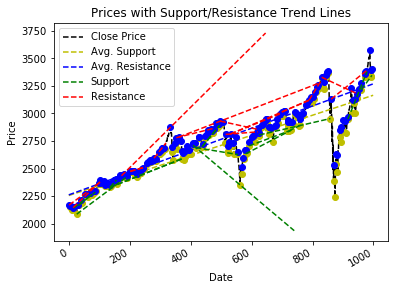

<Figure size 432x288 with 0 Axes>

In [6]:
fig = trendln.plot_support_resistance(hist[-1000:].Close) # requires matplotlib - pip install matplotlib
plt.savefig('charts/suppres.svg', format='svg')
plt.show()
plt.clf() #clear figure

In [ ]:
print("Fetching Data")
data = timscale_setup.get_full_table("BANKNIFTY_F1")
data.describe()
data.head()

In [3]:
print("Fetching using dbscrape")
banknifty_table = "BANKNIFTY_F1"

startdate = "2020-02-02 09:30:00"
enddate = "2020-02-29 15:30:00"

#data = dbscrape.gettablerange(*(timscale_setup.get_config()), banknifty_table, startdate, enddate)
rawdata = dbscrape.expirymonth(*(timscale_setup.get_config()), banknifty_table, 1, 2020)
rawdata.head()


Fetching using dbscrape


,datetime,internalname,open,high,low,close,volume,unknown,expirydate,exchange
0,2020-01-01 09:16:00,BANKNIFTY JAN FUT,32417.30,32465.15,32353.90,32456.05,36240,1304980,2020-01-30 23:59:00,NSE
1,2020-01-01 09:17:00,BANKNIFTY JAN FUT,32457.00,32466.00,32444.55,32444.55,18780,1304980,2020-01-30 23:59:00,NSE
2,2020-01-01 09:18:00,BANKNIFTY JAN FUT,32446.40,32452.00,32445.00,32445.00,14900,1316960,2020-01-30 23:59:00,NSE
3,2020-01-01 09:19:00,BANKNIFTY JAN FUT,32445.00,32463.65,32435.00,32463.65,18120,1316960,2020-01-30 23:59:00,NSE
4,2020-01-01 09:20:00,BANKNIFTY JAN FUT,32460.75,32474.00,32456.90,32465.00,11540,1316960,2020-01-30 23:59:00,NSE


In [1]:
import DLPriceModel

data, exp_data, int_name = DLPriceModel.getData()
max_offset = DLPriceModel.set_indicators(data)

print(max_offset)

True
['27ema', 26]


In [24]:
import datetime as dt

print(dt.datetime.fromtimestamp(rawdata["datetime"][100]))
rawdata["datetime"][100].time() < dt.time(15,30)

TypeError: an integer is required (got type Timestamp)

In [29]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(LSTM(100, input_shape=(22, 60)))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
lstm (LSTM)                  (None, 100)               64400
_________________________________________________________________
dropout (Dropout)            (None, 100)               0
_________________________________________________________________
dense (Dense)                (None, 4)                 404
Total params: 64,804
Trainable params: 64,804
Non-trainable params: 0
_________________________________________________________________


In [1]:
import DLPriceModel

test_record = "../data/tfrecords/dl_scaled_5_BANKNIFTY_F1_2020_1.tfrecords"
X, Y = DLPriceModel.create_dataset(test_record)
for i in range(len(X[0])):
    print(X[0][i][:3])

True
[[0.51987529]
 [0.53510904]
 [0.40490812]]
[[0.55115205]
 [0.54973185]
 [0.41527024]]
[[0.50280875]
 [0.38480276]
 [0.24850836]]
[[0.55115205]
 [0.4120172 ]
 [0.30700752]]
[[0.10161054]
 [0.39853588]
 [0.48784775]]
[[9.51422815e-08]
 [9.51400510e-08]
 [9.51378146e-08]]
[[0.58738774]
 [0.5344584 ]
 [0.47530866]]
[[0.7349329 ]
 [0.71575582]
 [0.68971562]]
[[0.56006223]
 [0.48604366]
 [0.39652163]]
[[0.62801898]
 [0.58481705]
 [0.52925354]]
[[0.70424324]
 [0.68337619]
 [0.65648705]]
[[0.17439504]
 [0.13484344]
 [0.08419872]]
[[0.7349329 ]
 [0.71575582]
 [0.68971562]]
[[0.94164366]
 [0.96351045]
 [0.98900312]]
[[0.52822208]
 [0.46800914]
 [0.39042813]]
[[0.31355083]
 [0.37585488]
 [0.45413032]]
[[0.47066024]
 [0.4895317 ]
 [0.50713003]]
[[0.68742263]
 [0.62060046]
 [0.55049354]]
[[1.30795504]
 [0.92278933]
 [0.71424436]]
[[0.58581674]
 [0.5341807 ]
 [0.46151894]]
[[0.59698105]
 [0.51324302]
 [0.47394186]]
[[0.81137431]
 [0.71382123]
 [0.69809139]]


In [27]:
from progress.bar import Bar
import time
bar = Bar('Processing', max=20)
for i in range(20):
    time.sleep(1)
    bar.next()
bar.finish()

In [5]:
rawdata.tail()

,datetime,internalname,open,high,low,close,volume,unknown,expirydate,exchange
8282,2020-01-30 15:27:00,BANKNIFTY JAN FUT,30646.1,30650.05,30646.1,30646.95,10060,982800,2020-01-30 23:59:00,NSE
8283,2020-01-30 15:28:00,BANKNIFTY JAN FUT,30646.5,30646.50,30644.0,30645.00,8060,956080,2020-01-30 23:59:00,NSE
8284,2020-01-30 15:29:00,BANKNIFTY JAN FUT,30645.0,30648.15,30645.0,30646.50,8800,956080,2020-01-30 23:59:00,NSE
8285,2020-01-30 15:30:00,BANKNIFTY JAN FUT,30646.5,30651.00,30643.0,30646.05,17880,956080,2020-01-30 23:59:00,NSE
8286,2020-01-30 19:10:00,BANKNIFTY JAN FUT,30647.4,30647.40,30647.4,30647.40,1,752360,2020-01-30 23:59:00,NSE


In [6]:
rawdata.describe()

,open,high,low,close,volume,unknown
count,8287.000000,8287.000000,8287.000000,8287.000000,8287.000000,8.287000e+03
mean,31575.527097,31583.678515,31567.039640,31575.351804,8756.903825,1.513477e+06
std,553.509037,552.732222,554.500414,553.605247,10114.273465,1.714051e+05
min,30522.000000,30527.900000,30513.450000,30521.000000,1.000000,7.523600e+05
25%,31060.000000,31068.250000,31051.225000,31060.000000,2970.000000,1.404680e+06
50%,31521.450000,31530.050000,31511.200000,31521.000000,5480.000000,1.480340e+06
75%,32129.875000,32139.000000,32120.975000,32129.875000,10660.000000,1.602380e+06
max,32600.000000,32606.050000,32594.000000,32602.050000,148260.000000,1.953660e+06


In [7]:
import charts

fplot = charts.FinPlotter(rawdata, format="db")
fplot.data.head()

TypeError: __init__() missing 1 required positional argument: 'instrumentname'

In [9]:
data_backtesting = strategys_backtesting.prepareData(rawdata, verbose=True)
data_backtesting.head()

Open      High       Low     Close  Volume
datetime                                                           
2020-01-01 09:16:00  32417.30  32465.15  32353.90  32456.05   36240
2020-01-01 09:17:00  32457.00  32466.00  32444.55  32444.55   18780
2020-01-01 09:18:00  32446.40  32452.00  32445.00  32445.00   14900
2020-01-01 09:19:00  32445.00  32463.65  32435.00  32463.65   18120
2020-01-01 09:20:00  32460.75  32474.00  32456.90  32465.00   11540


,Open,High,Low,Close,Volume
datetime,,,,,
2020-01-01 09:16:00,32417.30,32465.15,32353.90,32456.05,36240
2020-01-01 09:17:00,32457.00,32466.00,32444.55,32444.55,18780
2020-01-01 09:18:00,32446.40,32452.00,32445.00,32445.00,14900
2020-01-01 09:19:00,32445.00,32463.65,32435.00,32463.65,18120
2020-01-01 09:20:00,32460.75,32474.00,32456.90,32465.00,11540


In [73]:
indicators.SRLevels(data_backtesting[0:800])

AttributeError: 'DataFrame' object has no attribute 'High_15T'

In [71]:
timeframe=750
levels = []
levels.append((0, max(data.High[-timeframe:]))) # timeframe High (check if it is first candle of day)
levels.append((0, min(data.Low[-timeframe:]))) # timeframe Low (check if it is first candle of day)

df = pd.DataFrame()
# df.set_index(data_backtesting["datetime"][-timeframe:])
df["Open"] = data_backtesting["Open"][-timeframe:]
df["High"] = data_backtesting["High"][-timeframe:]
df["Low"] = data_backtesting["Low"][-timeframe:]
df["Close"] = data_backtesting["Close"][-timeframe:]
df["Volume"] = data_backtesting["Volume"][-timeframe:]
df["Date"] = pd.to_datetime(data_backtesting.index[-timeframe:])
# ohlc_dict = {                                                                                                             
# 'Open':'first',                                                                                                    
# 'High':'max',                                                                                                       
# 'Low':'min',                                                                                                        
# 'Close': 'last',                                                                                                    
# 'Volume': 'sum'
# }
# df.resample('5T', how=ohlc_dict, closed='left', label='left')
# df.resample('5T', label='left').agg({
#     'Open': 'first',
#     'High': 'max',
#     'Low': 'min',
#     'Close': 'last',
#     'Volume': 'sum'
# })
resample_len = 5
opens = []
highs = []
lows = []
closes = []
vols = []
for i in range(int(timeframe/resample_len)):
    highs.append(max(df["High"][i*resample_len:(i+1)*resample_len]))
    lows.append(min(df["Low"][i*resample_len:(i+1)*resample_len]))
    opens.append(df["Open"][i*resample_len])
    closes.append(df["Close"][(i+1)*resample_len-1])
    vols.append(sum(df["Volume"][i*resample_len:(i+1)*resample_len]))
# df = df.resample('5Min').ohlc()
candle_len=12
# for key, series in df.iteritems():
#     print(key)
#     print(series)
candle_mean = np.mean(np.array(highs)-np.array(lows))*3
for i in range(len(closes)):
    thisMax = max(highs[i:i+candle_len])
    thisMin = min(lows[i:i+candle_len])
    if thisMax - thisMin < 100:
        midPrice = (thisMax+thisMin)/2
        if np.sum([abs(midPrice-x[1]) < candle_mean  for x in levels]) == 0:
            levels.append((i+candle_len/2, midPrice))
# highs in 30 point range level
# lows in 30 point range level

df["Date"] = df["Date"].apply(date2num)
print(levels)


[(0, 31280.0), (0, 30513.45), (22.0, 31064.5), (104.0, 30635.65)]


In [60]:

df.reset_index(drop=True, inplace=True)
df.head()


,Open,High,Low,Close,Volume,Date
0,30920.10,30962.7,30920.1,30950.95,25680,737453.387500
1,30945.05,30958.4,30940.0,30945.00,10940,737453.388194
2,30943.35,30954.0,30930.8,30953.50,17020,737453.388889
3,30951.50,30952.4,30920.0,30934.35,13620,737453.389583
4,30935.05,30949.9,30928.5,30947.40,8700,737453.390278


In [68]:
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

0    737453.387500
1    737453.388194
2    737453.388889
3    737453.389583
4    737453.390278
Name: Date, dtype: float64


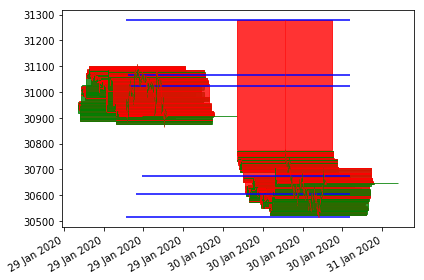

In [69]:
from mplfinance.original_flavor import candlestick_ohlc 
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
fig, ax = plt.subplots()

print(df["Date"].head())
candlestick_ohlc(ax,df[["Date", "Open", "High", "Low", "Close"]].values,width=0.6, \
                colorup='green', colordown='red', alpha=0.8)

date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

for level in levels:
    plt.hlines(level[1],xmin=df["Date"][level[0]],\
            xmax=max(df["Date"]),colors='blue')
fig.show()

In [6]:

fplot = charts.FinPlotter(data_backtesting)
fplot.data.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2020-02-28 09:16:00,29625.00,29650.00,29375.60,29587.75,146320
2020-02-28 09:17:00,29600.00,29635.95,29572.40,29594.65,70100
2020-02-28 09:18:00,29582.55,29582.55,29550.00,29580.00,64000
2020-02-28 09:19:00,29578.05,29636.20,29577.70,29592.00,35100
2020-02-28 09:20:00,29592.75,29665.25,29592.35,29638.20,43160


In [9]:
fplot.indiPlot(name=banknifty_table)

AttributeError: 'DataFrame' object has no attribute 'open'

In [8]:
ta.volatility.bollinger_hband(data_backtesting["Close"], 20, 2)

2020-03-27 09:16:00             NaN
2020-03-27 09:17:00             NaN
2020-03-27 09:18:00             NaN
2020-03-27 09:19:00             NaN
2020-03-27 09:20:00             NaN
                           ...     
2020-04-30 15:27:00    21558.079761
2020-04-30 15:28:00    21550.470075
2020-04-30 15:29:00    21542.249257
2020-04-30 15:30:00    21541.496941
2020-04-30 19:28:00    21541.281955
Name: hband, Length: 7914, dtype: float64

In [24]:
len(ta.volatility.bollinger_hband_indicator(data_backtesting["Close"], 20, 2))

8287

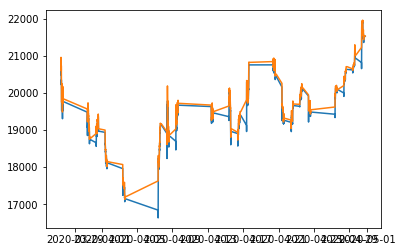

In [20]:


#plt.plot(data_backtesting.index[100:200], ta.volatility.bollinger_hband_indicator(data_backtesting["Close"][100:200], 20, 2))
plt.plot(data_backtesting.index, ta.volatility.bollinger_lband(data_backtesting["Close"], 20, 2))
#plt.plot(data_backtesting.index[100:200], ta.volatility.bollinger_mavg(data_backtesting["Close"][100:200], 20))
#plt.plot(data_backtesting.index[100:200], data_backtesting["Close"][100:200])

plt.plot(data_backtesting.index, ta.volume.volume_weighted_average_price(data_backtesting["High"],data_backtesting["Low"],data_backtesting["Close"], data_backtesting["Volume"], 14))
plt.show()

In [5]:

def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 13
    n2 = 32
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()



In [ ]:
class SmaCrossSignalTrail(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only
        
        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)


In [ ]:
from backtesting.test import GOOG

GOOG.head()

In [ ]:

bt = Backtest(GOOG, SmaCross, cash=10000, commission=.002)
stats = bt.run()
stats

In [6]:
bt_banknifty = Backtest(data_backtesting, SmaCross, cash=100000, commission=.002)
banknifty_stats = bt_banknifty.run()

print(banknifty_stats)

Start                     2020-01-01 09:16:00
End                       2020-01-30 19:10:00
Duration                     29 days 09:54:00
Exposure Time [%]                     99.0226
Equity Final [$]                      59647.8
Equity Peak [$]                        100000
Return [%]                           -40.3522
Buy & Hold Return [%]                 5.57261
Max. Drawdown [%]                    -40.3661
Avg. Drawdown [%]                    -40.3661
Max. Drawdown Duration       29 days 08:37:00
Avg. Drawdown Duration       29 days 08:37:00
# Trades                                  301
Win Rate [%]                          12.6246
Best Trade [%]                       0.864226
Worst Trade [%]                       -1.8407
Avg. Trade [%]                      -0.216793
Max. Trade Duration           2 days 18:39:00
Avg. Trade Duration           0 days 02:20:00
Profit Factor                        0.120486
Expectancy [%]                       0.275713
SQN                               

In [8]:
banknifty_stats["Return [%]"]

-40.352237700000146

In [ ]:

bt_banknifty.plot()

In [ ]:
bt.plot()

In [ ]:
%%time

stats = bt_banknifty.optimize(n1=range(8, 15, 1),
                    n2=range(20, 35, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
print(stats)

In [ ]:
print(stats._strategy)
stats.tail()

In [ ]:
bt_banknifty.plot(plot_volume=False, plot_pl=False)

In [ ]:
bt_banknifty._strategy.__name__